# GDSC ML fest

# KAZENERGY team
### participants:
### Islam-Bek Kurakbay
### Azamat Almatov
### Alikhan Mukhatov


<b> Captain telegram for any questions - @polotens

#### Steps:


> Unzip archive 


> Work with labels

> Augment data

> Create dataset class

> Split for train and validation

> Train model

> Submit

In [48]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install pathlib
!pip install pickle
!pip install torchvision
!pip install torch
!pip install unrar
!pip install patoolib
!pip install zipfile
!pip install sklearn
!pip install re


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


ERROR: Could not find a version that satisfies the requirement patoolib (from versions: none)
ERROR: No matching distribution found for patoolib
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=9a3791d69d1c10128c7febd6c9af9ad700073912daf9a24db4aa218b84b52343
  Stored in directory: c:\users\aliha\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot
import seaborn as sns
from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import math

from tqdm import tqdm, tqdm_notebook
from pathlib import Path
import pickle
import random

from torchvision import models
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import unrar
import patoolib
import os

import zipfile
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

In [2]:
# unzip archive
path_to_train_zip = Path('train_imgs.zip')
with zipfile.ZipFile(path_to_train_zip) as zip_ref:
    zip_ref.extractall(Path('train_imgs_train'))

In [3]:
path_to_train_zip = Path('test_imgs.zip')
with zipfile.ZipFile(path_to_train_zip) as zip_ref:
    zip_ref.extractall(Path('test_imgs'))

In [4]:
# inherit class from PyTorch Dataset class
class FireDataset(Dataset):
    # default constructor
    def __init__(self, files, mode, labels= None, transform = None, rescale_size = 224):
        self.files = files
        self.data_modes = ['train', 'test', 'val']
        self.mode = mode
        self.transform = transform
        self.rescale_size = rescale_size
        
        # raise error if mode not train test or val
        if self.mode not in self.data_modes:
            print(f"{self.mode} is not correct; correct modes: {self.data_modes}")
            raise NameError
        
        self.len_ = len(self.files)
        
        # assign labels if mode is not train
        if self.mode != 'test':
            self.labels = labels
    
    # get len of dataset
    def __len__(self):
        return self.len_
    
    # load one sampe
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    # get items
    def __getitem__(self, index):
        transform = self.transform
        if transform is None:
            # create transformer
            transform = transforms.Compose([
                # transfrom to tensor
                transforms.ToTensor(),
                # normalise tensor
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
            ])
        
        # load images with given indexes
        x = self.load_sample(self.files[index])
        # resize and convert to numpy array
        x = self._prepare_sample(x)
        
        # transform samples
        x = transform(x)
        
        # if mode is test, return images wothout labels
        if self.mode == 'test':
            return x
        else:
            # choose labels with given indexes
            y = self.labels[index]
            # return images with samples
            return x, y
    def _prepare_sample(self, image):
        # resize image
        image = image.resize((self.rescale_size, self.rescale_size))
        # return numpy array of image
        return np.array(image)


In [5]:
# sort labels dataframe
labels = pd.read_csv('train_labels.csv', names = ['image', 'class'])
# remove non digits character
labels['image'] = labels['image'].str.replace(r'\D+', '')
labels = labels.sort_values(by='image')
# convert to numpy
labels_numpy = labels['class'].to_numpy()

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1107548695.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  labels['image'] = labels['image'].str.replace(r'\D+', '')


In [6]:
labels, labels_numpy

(     image  class
 446     10      1
 1807  1001      0
 801   1002      1
 1213  1009      1
 2243  1012      0
 ...    ...    ...
 210   9986      1
 2528  9987      0
 1334  9989      1
 2593  9995      0
 631   9997      1
 
 [2619 rows x 2 columns],
 array([1, 0, 1, ..., 1, 0, 1], dtype=int64))

In [7]:
# get train and test directories
train_dir = Path('train_imgs_train/train_imgs')
test_dir = Path('test_imgs/test_imgs')

# train and test files
train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

print(f'Length of train files is {len(train_files)}, Length of test files is {len(test_files)}')

DEVICE ='cuda'

Length of train files is 2619, Length of test files is 400


### Look at labels

<AxesSubplot:ylabel='image'>

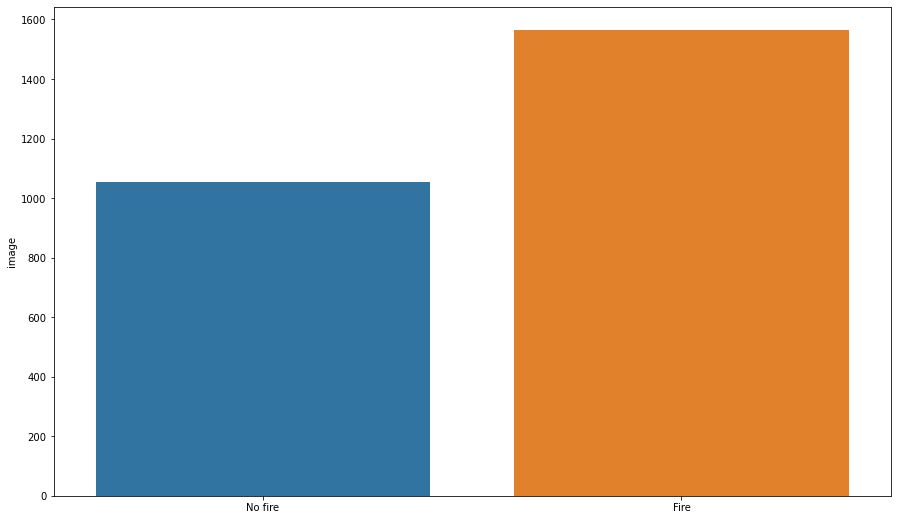

In [8]:
count_df = labels.groupby('class').count()
plt.figure(figsize=(15,9))
sns.barplot(x = ['No fire', 'Fire'], y = count_df['image'])

The dataset is unbalanced, need to increase its size by augmentation

In [9]:
def get_count(labels):
    """
    function get labels as parametres, return dataframe with count labels
    """
    labels.rename(columns={'picture':'count'}, inplace = True)
    return labels.groupby('class').count()

In [10]:
def number_images_to_add(dataframe, limit):
    """
    function accepts dataframe and limit of images as parametr
    return dataframe
    """
    dataframe['to_add'] = dataframe['image'].apply(lambda x: limit - x if x < limit else 0)
    dataframe['one_iteration'] = dataframe.apply(lambda x: math.ceil(x['to_add'] / x['image']), axis=1)
    return dataframe

In [11]:
get_count(labels)

,image
class,
0,1054
1,1565


In [12]:
#number_images_to_add(count_df, 500)
count_labels = get_count(labels)
limit = 1565
number_images_to_add(count_labels, limit)

,image,to_add,one_iteration
class,,,
0,1054,511,1
1,1565,0,0


In [13]:
def show_random_images(dataset):
  # show random 9 images
  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
  for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val, label = dataset[random_characters]
    img_label = label
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [14]:
def load_image(file):
    """function to load image"""
    image = Image.open(file)
    image.load()
    return image

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
def plot_results_of_model(train_loss, val_loss, train_acc, val_acc):
    figure, ax = plt.subplots(2)
    ax[0].plot(train_loss)
    ax[0].plot(val_loss)
    plt.xlabel("epoch")
    ax[0].legend(['train_loss', 'val_loss'])
    
    ax[1].plot(train_acc)
    ax[1].plot([i.cpu() for i in val_acc])
    plt.xlabel("epoch")
    ax[1].legend(['train_acc', 'val_acc'])
    
    figure.set_figheight(15)
    figure.set_figwidth(12)

### Netx step is image augmentation. We need to augment fire image, to make dataset balanced

In [17]:
data = get_count(pd.read_csv('train_labels.csv', names=['image','class']))
limit = 1565
number_images_to_add(data, limit)

,image,to_add,one_iteration
class,,,
0,1054,511,1
1,1565,0,0


One of three augmenters will be randomly applied to the <b>non fire images in train dataset

In [18]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

<b>Augment non fire images, to balance dataset<b>

In [19]:
counter, limit = 0, get_count(labels)['image'].max() - get_count(labels)['image'].min()
for i, image_path in tqdm(enumerate(train_files)):
    path = image_path.parents[0]
    img = load_image(image_path)
    if labels_numpy[i] == 0:
        # choose on of three augmenters
        augmenter = random.choice(list(augmenters.values()))
        # augment image
        aug_img = augmenter(img)
        # save image in format "{i}_1.jpg"
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{1}.jpg") 
        dir_str = str(image_path.name)
        labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
        # if image is saved, increment count variable
        counter += 1
    if counter == limit:
        # limit as different betwenn count of two classes
        break

1it [00:00,  4.31it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
3it [00:00,  9.61it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
5it [00:00,  8.73it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
10it [00:00, 16.65it/s]C:\Users\aliha\Ap

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
73it [00:04, 21.63it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: 

149it [00:10, 26.66it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
153it [00:10, 15.83it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

215it [00:14, 15.39it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
218it [00:15, 17.42it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
227it [00:15, 23.02it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\

284it [00:18, 14.51it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
290it [00:18, 19.75it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
294it [00:18, 21.80it/s]C:\Users\aliha\AppData\Local\Temp\

360it [00:22, 18.25it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
363it [00:22, 16.42it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
373it [00:22, 28.73it/s]C:\Users\aliha\AppData\Local\Temp\

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
441it [00:26, 16.83it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
443it [00:26, 17.32it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

495it [00:29, 17.11it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
498it [00:29, 16.60it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
500it [00:30,  8.16it/s]C:\Users\aliha\AppData\Local\Temp\

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
560it [00:34, 15.66it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
563it [00:35, 14.80it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

622it [00:37, 25.63it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
625it [00:39,  7.54it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

679it [00:43, 22.08it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
682it [00:43, 23.41it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

735it [00:46,  8.64it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
738it [00:47,  9.10it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
740it [00:47,  8.87it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
744it [00:47, 12.05it/s]C:\Users\a

805it [00:50, 24.98it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
808it [00:50, 23.11it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
815it [00:51, 24.95it/s]C:\Users\aliha\AppData\Local\Temp\

869it [00:54, 12.86it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
873it [00:54, 17.27it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
876it [00:55, 18.16it/s]C:\Users\aliha\AppData\Local\Temp\

939it [00:58, 25.90it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
943it [00:59, 19.40it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\12916510

1013it [01:03, 19.25it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1016it [01:03, 13.43it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1018it [01:03, 12.03it/s]C:\Users\aliha\AppData\Local\Te

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1075it [01:06, 14.75it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1079it [01:06, 18.37it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\129165

C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1141it [01:10, 20.38it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1144it [01:10, 17.00it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\129165

1207it [01:13, 25.58it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1211it [01:13, 27.80it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1214it [01:13, 28.04it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Te

1278it [01:19, 14.47it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1280it [01:19, 14.19it/s]C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
C:\Users\aliha\AppData\Local\Temp\ipykernel_14680\1291651059.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = labels.append({'image':dir_str.replace('.jpg', '')+'_', 'class':0},ignore_index=True)
1283it [01:19, 15.80it/s]C:\Users\aliha\AppData\Local\Te

In [20]:
labels = labels.sort_values(by='image')
labels_numpy_aug = labels['class'].to_numpy()

In [21]:
labels

,image,class
0,10,1
1,1001,0
2619,1001_,0
2,1002,1
3,1009,1
...,...,...
2614,9986,1
2615,9987,0
2616,9989,1
2617,9995,0


In [22]:
train_files = list(train_dir.rglob('*.jpg'))
print(f'Length of train files after augmentation is {len(train_files)}')

Length of train files after augmentation is 3130


In [23]:
# split files into train and val
train_aug_files, val_aug_files = train_test_split(train_files, train_size=0.8,shuffle = False)
# split labels
train_labels, val_labels = train_test_split(labels_numpy_aug,train_size=0.8,shuffle = False)

In [24]:
# create datasets
train_dataset = FireDataset(files=train_aug_files, mode = 'train', labels=train_labels)
val_dataset = FireDataset(files=val_aug_files, mode = 'val', labels=val_labels)

In [25]:
# train dataset
test_dataset = FireDataset(files = test_files, mode = 'test')

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    fit one epoch
    """
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion):
    """
    get validate loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        with torch.set_grad_enabled(False):
            # get predictions of model
            outputs = model(inputs)
            # calculate loss
            loss = criterion(outputs, labels)
            # convert propabiliteis to binary array
            preds = torch.argmax(outputs, 1)
        # sum up loss
        running_loss += loss.item() * inputs.size(0)
        # number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        # total number of images
        processed_size += inputs.size(0)
    #validate loss
    val_loss = running_loss / processed_size
    # validate accuracy
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [29]:
def train(train_files, val_files, model, epochs, batch_size, opt, scheduler):
    
    """
    function trains model N times, where N is number of epochs
    """
    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # assign optimizer and scheduler
        scheduler = scheduler
        opt = opt
        criterion = nn.CrossEntropyLoss()


        for epoch in range(epochs):
            # fit one epoch
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            # evaluate epoch
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            # step of scheduler
            scheduler.step()
            
    return history

In [30]:
def predict(model, test_loader):
    """
    predict function
    """
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
def predict_pictures(model, dataset):
    """
    show 9 random images from dataset and model predictions on them
    """
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,len(test_dataset)-1))
        im_val = dataset[random_characters]



        imshow(im_val.data.cpu(), \
              plt_ax=fig_x)


        fig_x.add_patch(patches.Rectangle((0, 53),40,20,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("serif")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)
        if y_pred == 0:
            label_test_pred = 'Normal'
        elif y_pred == 1:
            label_test_pred = 'Fire'



        fig_x.text(1, 59, label_test_pred , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black')

In [32]:
def initialise_model(model_name, num_classes, tune_conv_layer = False, use_pretrained=True):
        """
        Были прове
        """
    
        model_ft = None
        if model_name == 'resnet':
            # resnet
            model_ft = models.resnet18(pretrained = use_pretrained)
            for param in model_ft.parameters():
                param.requires_grad = False
            num_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_features, num_classes)
            input_size = 224

        if model_name == 'alexnet':
            """
            AlexNet
            """
            model_ft = models.alexnet(pretrained = use_pretrained)
            for param in model_ft.parameters():
                param.requires_grad = False
            num_features = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_features,num_classes)
            input_size = 224
    
        if model_name == 'densenet':
            """
            DenseNet
            """

            model_ft = models.densenet121(pretrained = use_pretrained)
            for param in model_ft.parameters():
                param.requires_grad = False
            num_features = model_ft.classifier.in_features
            model_ft.classifier = nn.Linear(num_features, num_classes)
        return model_ft

<b> We will use pretrained AlexNet neural network, and AdamW as optimizer

In all next experiments, we will use Cross Entropy as loss function

$NLL(y) = -{\log(p(y))}$

$\min_{\theta} \sum_y {-\log(p(y;\theta))}$

$\max_{\theta} \prod_y p(y;\theta)$

In [49]:
alexnet = initialise_model('alexnet', 2).to('cuda')

# use Adam stochatic gradient descent
optimizer_ft = torch.optim.AdamW(alexnet.parameters(), lr=1e-3, amsgrad=True)

# every 3 epochs increase learning rate
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)



C:\Users\aliha\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\aliha\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:   0%|                                                                                     | 0/6 [00:00<?, ?it/s]

loss 0.10102981025912462


epoch:  17%|████████████▊                                                                | 1/6 [01:03<05:18, 63.66s/it]


Epoch 001 train_loss: 0.1010     val_loss 0.0318 train_acc 0.9605 val_acc 0.9840
loss 0.029893663254367132


epoch:  33%|█████████████████████████▋                                                   | 2/6 [02:00<03:59, 59.90s/it]


Epoch 002 train_loss: 0.0299     val_loss 0.0278 train_acc 0.9920 val_acc 0.9888
loss 0.01345041202962028


epoch:  50%|██████████████████████████████████████▌                                      | 3/6 [02:58<02:56, 58.75s/it]


Epoch 003 train_loss: 0.0135     val_loss 0.0259 train_acc 0.9976 val_acc 0.9920
loss 0.006983957343776458


epoch:  67%|███████████████████████████████████████████████████▎                         | 4/6 [03:58<01:58, 59.27s/it]


Epoch 004 train_loss: 0.0070     val_loss 0.0251 train_acc 0.9996 val_acc 0.9904
loss 0.006672603464997805


epoch:  83%|████████████████████████████████████████████████████████████████▏            | 5/6 [04:47<00:55, 55.65s/it]


Epoch 005 train_loss: 0.0067     val_loss 0.0248 train_acc 0.9996 val_acc 0.9904
loss 0.006297912332229316


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [05:43<00:00, 57.21s/it]



Epoch 006 train_loss: 0.0063     val_loss 0.0242 train_acc 0.9996 val_acc 0.9904


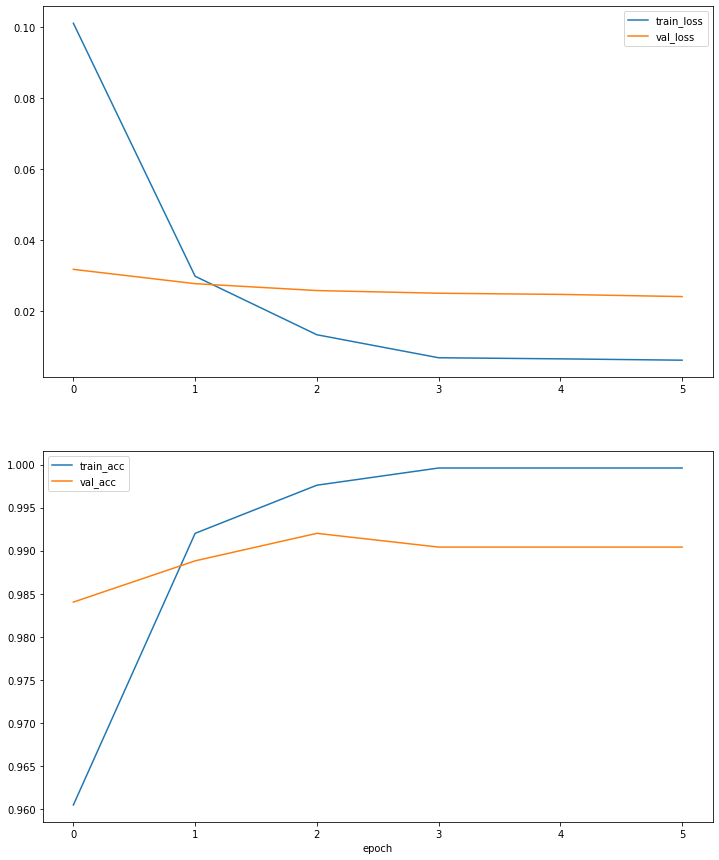

In [50]:
# train model
history = train(train_dataset, val_dataset, alexnet, epochs=6, opt = optimizer_ft, scheduler = exp_lr_scheduler, batch_size = 64)
loss, acc, val_loss, val_acc = zip(*history)
plot_results_of_model(loss, val_loss, acc, val_acc)


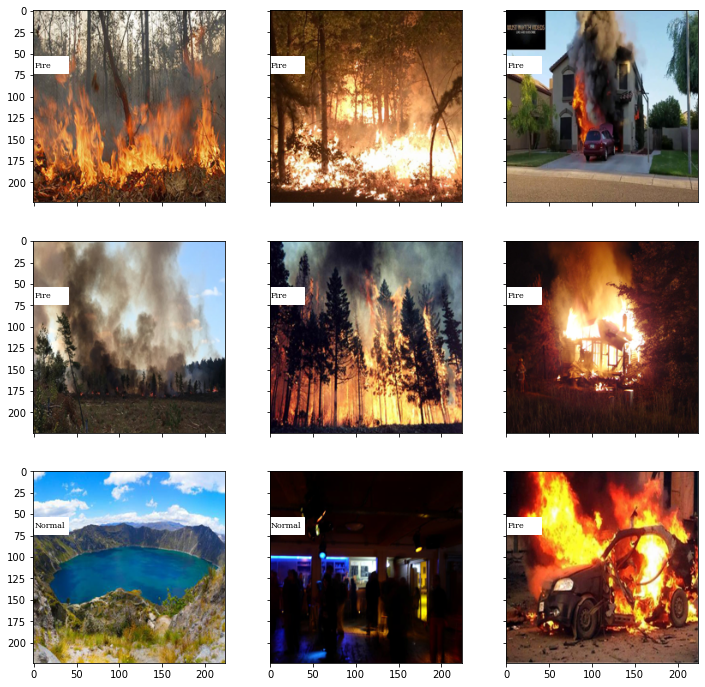

In [53]:
# show random 9 images and predictions of AlexNet on them
predict_pictures(alexnet, test_dataset)

<b> Use pretrained ResNet

C:\Users\aliha\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch:   0%|                                                                                     | 0/6 [00:00<?, ?it/s]

loss 0.4168900931224275


epoch:  17%|████████████▊                                                                | 1/6 [00:47<03:59, 47.98s/it]


Epoch 001 train_loss: 0.4169     val_loss 0.1845 train_acc 0.8159 val_acc 0.9633
loss 0.16423340979665993


epoch:  33%|█████████████████████████▋                                                   | 2/6 [01:34<03:07, 46.83s/it]


Epoch 002 train_loss: 0.1642     val_loss 0.1243 train_acc 0.9617 val_acc 0.9744
loss 0.11635978915059147


epoch:  50%|██████████████████████████████████████▌                                      | 3/6 [02:19<02:18, 46.17s/it]


Epoch 003 train_loss: 0.1164     val_loss 0.0937 train_acc 0.9732 val_acc 0.9824
loss 0.09953538264139011


epoch:  67%|███████████████████████████████████████████████████▎                         | 4/6 [03:08<01:34, 47.33s/it]


Epoch 004 train_loss: 0.0995     val_loss 0.0890 train_acc 0.9784 val_acc 0.9856
loss 0.09737082192311272


epoch:  83%|████████████████████████████████████████████████████████████████▏            | 5/6 [03:57<00:47, 47.89s/it]


Epoch 005 train_loss: 0.0974     val_loss 0.0866 train_acc 0.9800 val_acc 0.9856
loss 0.09522992577225256


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [04:43<00:00, 47.17s/it]


Epoch 006 train_loss: 0.0952     val_loss 0.0854 train_acc 0.9792 val_acc 0.9856


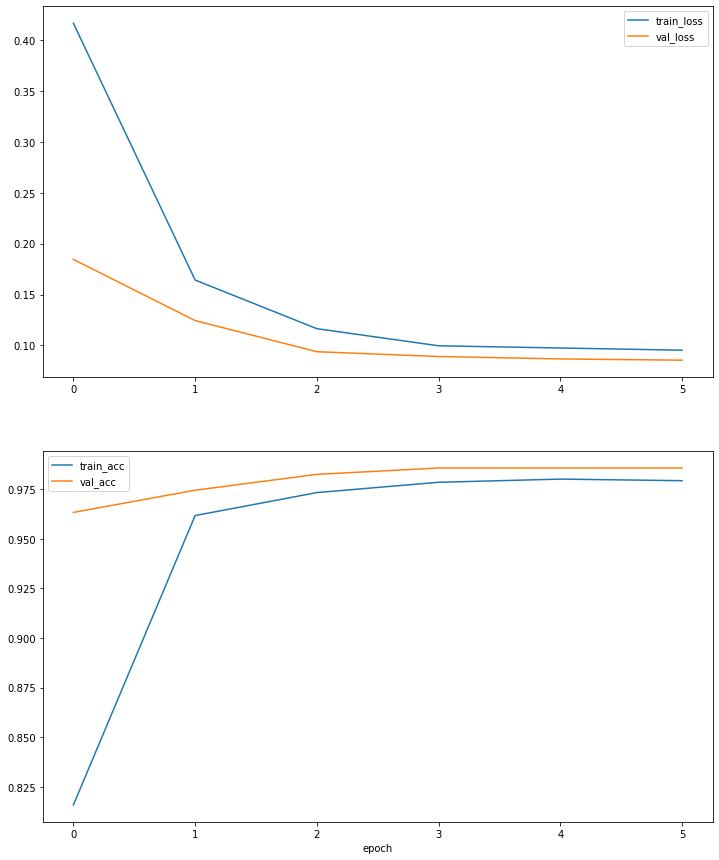

In [36]:
resnet = initialise_model('resnet', 2).to('cuda')

optimizer_ft = torch.optim.AdamW(resnet.parameters(), lr=1e-3, amsgrad=True)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

history = train(train_dataset, val_dataset, resnet, epochs=6, opt = optimizer_ft, scheduler = exp_lr_scheduler, batch_size = 64)
loss, acc, val_loss, val_acc = zip(*history)
plot_results_of_model(loss, val_loss, acc, val_acc)


<b> Next model is DenseNet

C:\Users\aliha\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch:   0%|                                                                                     | 0/6 [00:00<?, ?it/s]

loss 0.3399850327176408


epoch:  17%|████████████▊                                                                | 1/6 [01:33<07:45, 93.11s/it]


Epoch 001 train_loss: 0.3400     val_loss 0.1838 train_acc 0.8874 val_acc 0.9601
loss 0.13655239876847677


epoch:  33%|█████████████████████████▋                                                   | 2/6 [02:55<05:48, 87.06s/it]


Epoch 002 train_loss: 0.1366     val_loss 0.1154 train_acc 0.9708 val_acc 0.9728
loss 0.09871415436839143


epoch:  50%|██████████████████████████████████████▌                                      | 3/6 [04:26<04:26, 88.83s/it]


Epoch 003 train_loss: 0.0987     val_loss 0.0843 train_acc 0.9788 val_acc 0.9872
loss 0.08295796309321071


epoch:  67%|███████████████████████████████████████████████████▎                         | 4/6 [05:59<03:00, 90.18s/it]


Epoch 004 train_loss: 0.0830     val_loss 0.0855 train_acc 0.9844 val_acc 0.9856
loss 0.08098875128994354


epoch:  83%|████████████████████████████████████████████████████████████████▏            | 5/6 [07:14<01:24, 84.81s/it]


Epoch 005 train_loss: 0.0810     val_loss 0.0829 train_acc 0.9840 val_acc 0.9856
loss 0.0794376401950757


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [08:39<00:00, 86.52s/it]



Epoch 006 train_loss: 0.0794     val_loss 0.0820 train_acc 0.9852 val_acc 0.9888


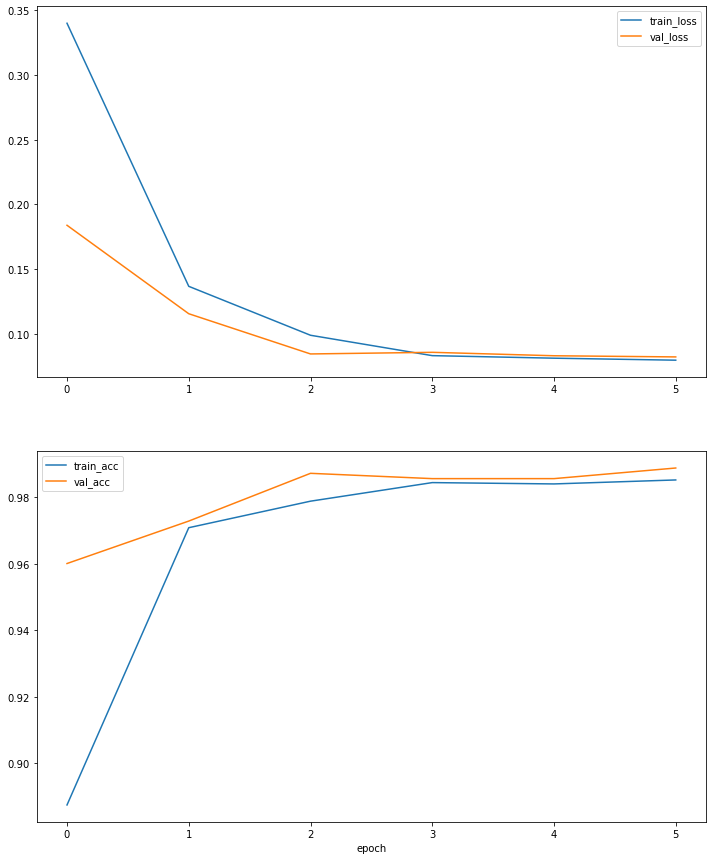

In [37]:
densenet = initialise_model('densenet', 2).to('cuda')

optimizer_ft = torch.optim.AdamW(densenet.parameters(), lr=1e-3, amsgrad=True)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

history = train(train_dataset, val_dataset, densenet, epochs=6, opt = optimizer_ft, scheduler = exp_lr_scheduler, batch_size = 64)
loss, acc, val_loss, val_acc = zip(*history)
plot_results_of_model(loss, val_loss, acc, val_acc)

<b>_Results of each model that was used_

> AlexNet - 0.9904

>ResNet - 0.9824

>DenseNet - 0.9808

# Conclusion 

<b>One of the main problems was the imbalance of the dataset. There were 1.5 times more images with fire than without fire. It was necessary to equalize the number of images of both classes. This problem was solved by augmentation of images without fire.  A random transformer augmentator was applied to images without fire, which included image cropping, mirroring and rotation.

Experiments were conducted using AlexNet, Reset, Densit. Alex Net showed the highest results, validation accuracy - 0.9904, validation loss - 0.0242 . This particular model was chosen for the final summit. During the training of the models, the following parameters and optimizers were used: the number of epochs - 6, the size of the batch - 64, StepLR was used as a scheduler, which increases the learning rate by 0.1 every 3 epochs.

# Submission

In [51]:
def save_submission(model, test_dataset, output_path = './submission.csv'):
    #function saves submission as csv file
    test_dataset_submission = FireDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)
    
    preds = np.argmax(probs, 1)
                    
    test_filenames = [path.name for path in test_dataset.files]
    my_submit = pd.DataFrame()
    my_submit['Id'] = test_filenames
    
    
    my_submit['Expected'] = preds
    
    my_submit.to_csv(output_path, index=False)
    
    return my_submit

AlexNet will be used for submission

In [52]:
save_submission(alexnet, test_dataset).head(5)

,Id,Expected
0,10.jpg,0
1,101.jpg,1
2,102.jpg,0
3,105.jpg,1
4,109.jpg,0
